# CMPT 459 Project - MLB Batting Analysis
By Ichiro Wang and Ajax Mok

GitHub repo <a href="https://github.com/ichiro-wang/mlb-batting-analysis" target="_blank">here</a>

Dataset from Kaggle <a href="https://www.kaggle.com/datasets/beckettnewton/mlb-hitting-pitching-data-2015-2024" target="_blank">here</a>

The terms "batter" and "hitter" may be used interchangeably in this notebook. They mean the same thing. 

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## Loading Data

In [110]:
data_path = "../data/raw/batting_2015_2024.csv"
data = pd.read_csv(data_path)
print(f"Loaded file: {data_path}")
total_samples, total_features = data.shape[0], data.shape[1]
print(f"Dimensions: {total_samples} samples, {total_features} features")

Loaded file: ../data/raw/batting_2015_2024.csv
Dimensions: 14051 samples, 321 features


Before we get started, we will fix columns we know are problematic.

For some reason there is an extra "season" column that contains the same values as the "Season" column, so we will remove one of them.

The "Age Rng" column that contains "Age" values in a weird format. We will remove "Age Rng".

There is a "Dol" column that contains dollar values with dollar signs, which makes pandas believe it is categorical. We will fix this.

You can do a quick eye-test in the data file to verify these columns for yourself.

In [111]:
# dealing with duplicate season columns
is_dup = data["Season"].equals(data["season"])
print(f"\nCheck if 'Season' and 'season' columns are duplicates: {is_dup}")
if is_dup:
    data = data.drop(columns=["season"])

# dealing with duplicate age/age-rng columns
data["Age Rng"] = data["Age Rng"].astype(str).str.extract(r"(\d+)").astype(int)
is_dup = data["Age"].equals(data["Age Rng"])
print(f"\nCheck if 'Age' and 'Age Rng' are duplicates: {is_dup}")
if is_dup:
    data = data.drop(columns=["Age Rng"])

# dealing with dollar formatting
# parentheses represent negative dollar values
data["Dol"] = (
    data["Dol"]
    .str.replace("$", "", regex=False)
    .str.replace("(", "-", regex=False)
    .str.replace(")", "", regex=False)
    .astype(float)
)


Check if 'Season' and 'season' columns are duplicates: True

Check if 'Age' and 'Age Rng' are duplicates: True


## Data Overview

In [112]:
print("First 5 Rows")
print(data.head(5))

print("\nFeature types:")

print("\nCategorical features:")
categorical_features = data.select_dtypes(include=["object"]).columns
for feat in categorical_features:
    print(f"{feat}: {data[feat].nunique()} unique values")

print("\nNumerical features: Everything else")
numerical_features = [feat for feat in data.columns if feat not in categorical_features]

print(f"Seasons: {data["Season"].unique().min()} - {data["Season"].unique().max()}")
print(f"Ages: {data["Age"].unique().min()} - {data["Age"].unique().max()}")
print("etc.")
print(data.describe())

First 5 Rows
    IDfg  Season              Name Team  Age    G   AB   PA    H   1B  ...  \
0  11579    2015      Bryce Harper  WSN   22  153  521  654  172   91  ...   
1  10155    2015        Mike Trout  LAA   23  159  575  682  172   93  ...   
2   5038    2015    Josh Donaldson  TOR   29  158  620  711  184  100  ...   
3   4314    2015        Joey Votto  CIN   31  158  545  695  171  107  ...   
4   9218    2015  Paul Goldschmidt  ARI   27  159  567  695  182  109  ...   

   maxEV  HardHit  HardHit%  Events  CStr%   CSW%    xBA   xSLG  xwOBA  L-WAR  
0  116.0    188.0     0.477     394  0.118  0.226  0.292  0.544  0.418    9.3  
1  117.7    205.0     0.486     422  0.207  0.282  0.297  0.588  0.422    9.3  
2  113.6    232.0     0.465     499  0.145  0.255  0.279  0.545  0.390    8.7  
3  109.3    175.0     0.425     412  0.177  0.254  0.289  0.541  0.422    7.3  
4  114.0    197.0     0.465     424  0.181  0.266  0.279  0.558  0.403    7.2  

[5 rows x 319 columns]

Feature types

## Project Focus

Before we start plotting and preprocessing data, we want to consider the focus of this project: analyzing batting performance. 

The dataset we use also includes batting performance from pitchers. We want to remove these values to focus on batting performance from regular players, rather than pitchers.

More discussed in Plate Appearance Distribution section below.

## Plate Appearance (PA) distribution

MLB defines a PA as a batter's turn at the plate. Or simply, each turn to hit. This is different than an at-bat (AB), because a PA includes every completed trip to the plate, while an AB only counts outcomes that don't include walks, hit-by-pitches (HBP), etc.

Some players, such as pitchers, don't get many opportunities to hit (only get a few PA's), or have many less PA's than regular players.

MLB recently implemented a rule that exempts all pitchers from needing to also hit. 

This means predicting a pitchers hitting ability is not particularly useful, given that they are no longer hitting. 

Regular players with limited PA's are also not as useful, as their stats are more prone to be influenced by luck. More discussed in the PA Threshold section below.

We will see how many players fall above specific PA thresholds and filter them based on the result.

In [113]:
print("Plate Appearance distribution")
print(data["PA"].describe())

pa_thresholds = [50, 100, 150, 200, 250, 300, 400, 500]
print(
    "\nPA's by threshold. These represent how many players had more PA's than these thresholds."
)
for threshold in pa_thresholds:
    split = data[data["PA"] >= threshold]
    print(f"PA >= {threshold}: {len(split)} samples")

Plate Appearance distribution
count    14051.000000
mean       122.559391
std        194.537007
min          0.000000
25%          0.000000
50%          6.000000
75%        182.000000
max        753.000000
Name: PA, dtype: float64

PA's by threshold. These represent how many players had more PA's than these thresholds.
PA >= 50: 5336 samples
PA >= 100: 4375 samples
PA >= 150: 3822 samples
PA >= 200: 3340 samples
PA >= 250: 2865 samples
PA >= 300: 2492 samples
PA >= 400: 1863 samples
PA >= 500: 1248 samples


## Setting a PA Threshold

According to the MLB Rate Stats Qualifiers ([link](https://www.mlb.com/glossary/standard-stats/rate-stats-qualifiers)), a batter must record at least 3.1 PA's per scheduled league game to qualify for certain invididual stat category leadership. 

Over a full season (162 games), this adds up to 502 PA's. 

Setting the threshold high, such as 500, shrinks our dataset to just 1248 samples. 

Setting it too low, such as 100, provides many more samples, but less PA's means stats could be more influenced by luck or randomness.

$\sigma_{300} / \sigma_{100} = \sqrt{100/300}= 0.577$

$\sigma^{2}_{300} / \sigma^{2}_{100} = 0.333$

$\sigma_{500} / \sigma_{300} = \sqrt{300/500}= 0.775$

$\sigma^{2}_{500} / \sigma^{2}_{300} = 0.600$

Going from 100 -> 300 PA's reduces $\sigma$ by roughly $42$%

Going from 300 -> 500 PA's reduces $\sigma$ by roughly $22$%

A threshold of 300 gives us a decent dataset size while reducing the influence of luck on player stats. 

## Filtering by PA Threshold

In [114]:
PA_THRESHOLD = 250
data = data[data["PA"] >= PA_THRESHOLD]

print(f"\nRemaining samples after filtering by PA: {len(data)}")
print(f"Samples removed: {total_samples - len(data)}")


Remaining samples after filtering by PA: 2865
Samples removed: 11186


## Plotting Distributions

Now that we've set our focus on regular batters, we will take a look at the distributions of some key stats.

### Some definitions of key stats for reference:

| Stat | Meaning | Brief Explanation |
|------|----------|-------------------|
| **AVG** | Batting Average | How often a hitter gets a hit (hits / at-bats). |
| **OBP** | On-Base Percentage | How often a hitter reaches base (includes hits, walks, and hit-by-pitches). |
| **SLG** | Slugging Percentage | Measures power by total bases per at-bat. |
| **OPS** | On-Base Plus Slugging | Combines on-base ability and power (OBP + SLG). |
| **HR** | Home Runs | Total number of home runs hit. |
| **BB%** | Walk Rate | Percentage of plate appearances ending in a walk. |
| **K%** | Strikeout Rate | Percentage of plate appearances ending in a strikeout. |
| **EV** | Exit Velocity | Average speed of the ball off the bat (in mph). |
| **Spd** | Speed | A 0-10 metric estimating a player’s running speed. |
| **wOBA** | Weighted On-Base Average | Like OBP in structure but assigns realistic weights to each outcome for a truer measure of offensive value. |
| **wRC+** | Weighted Runs Created Plus | Overall offensive value vs. league average (100 = average; 120 = 20% above average). |



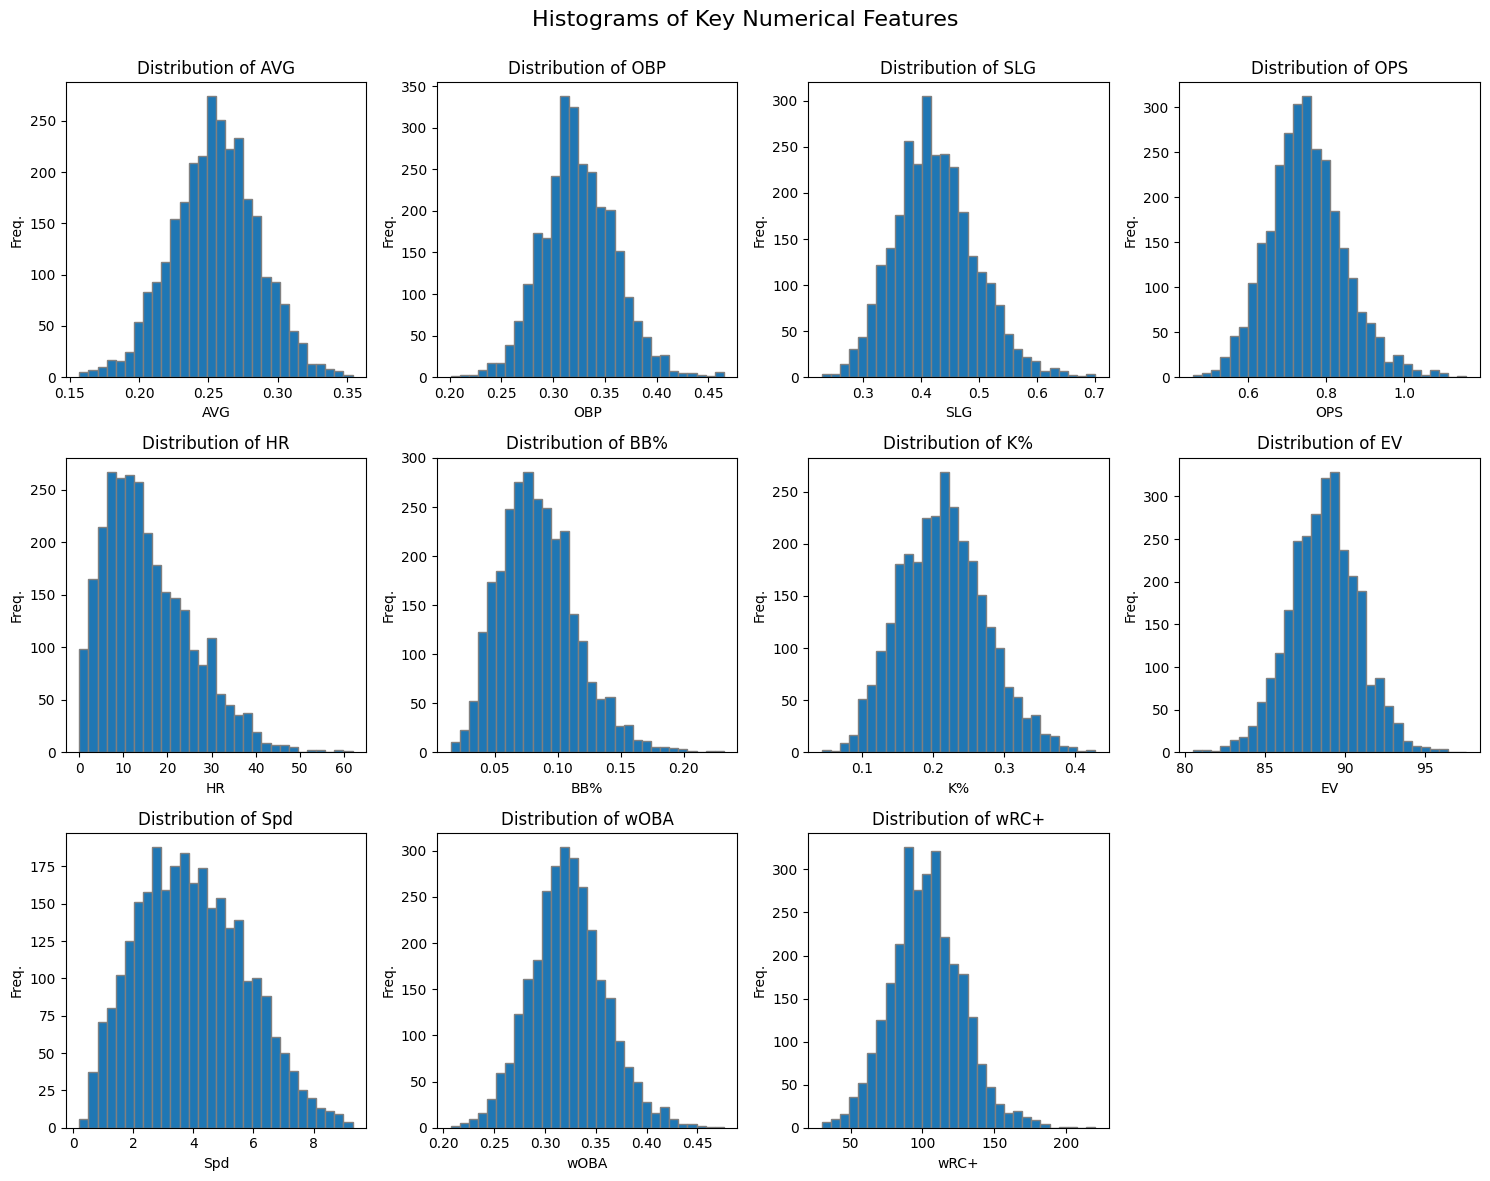

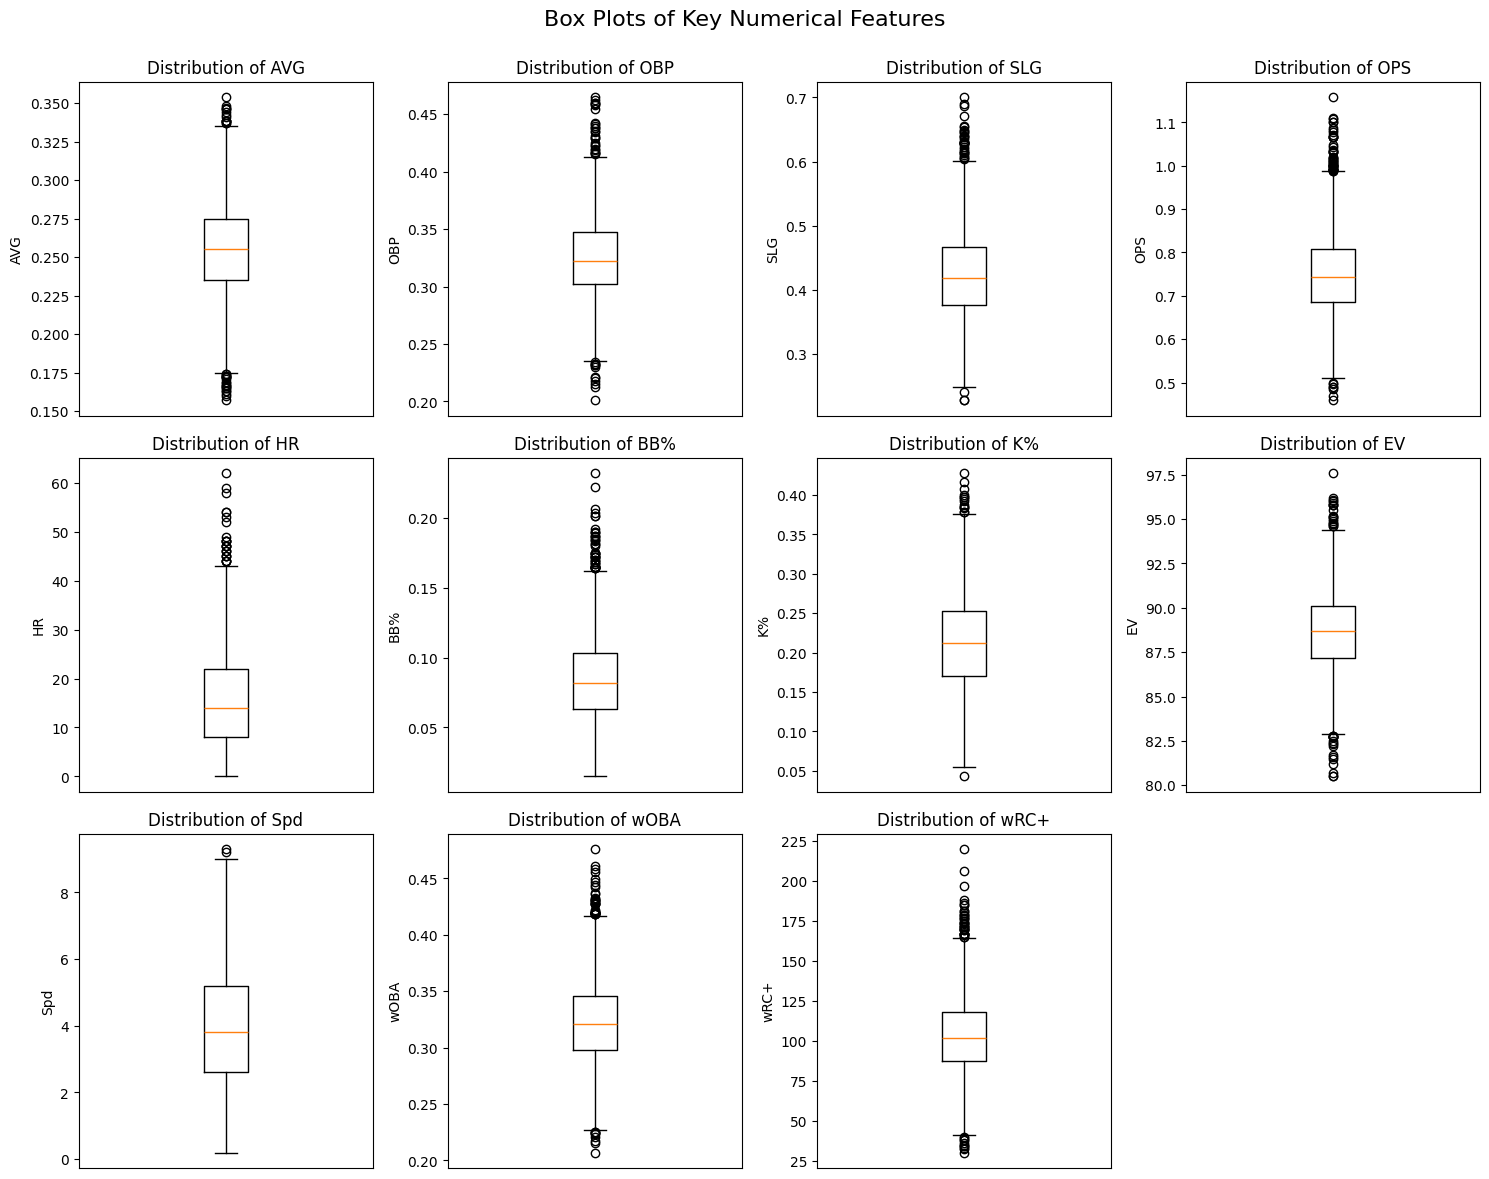

In [115]:
key_stats = ["AVG", "OBP", "SLG", "OPS", "HR", "BB%", "K%", "EV", "Spd", "wOBA", "wRC+"]

# histograms
fig, axs = plt.subplots(3, 4, figsize=(15, 12))
axs = axs.ravel()  # flatten to 1D array

for i, stat in enumerate(key_stats):
    axs[i].hist(data[stat], bins=30, edgecolor="grey")
    axs[i].set_title(f"Distribution of {stat}")
    axs[i].set_xlabel(stat)
    axs[i].set_ylabel("Freq.")

# hide remaining axes
for ax in axs[len(key_stats) :]:
    ax.set_visible(False)

plt.suptitle("Histograms of Key Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# box plots
fig, axs = plt.subplots(3, 4, figsize=(15, 12))
axs = axs.ravel()  # flatten to 1D array

for i, stat in enumerate(key_stats):
    axs[i].boxplot(data[stat])
    axs[i].set_title(f"Distribution of {stat}")
    axs[i].set_xticks([])
    axs[i].set_ylabel(stat)

# hide remaining axes
for ax in axs[len(key_stats) :]:
    ax.set_visible(False)

plt.suptitle("Box Plots of Key Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Visualizing Relationships

Features with high correlation (>= +-0.8):
OPS, wOBA: 0.9908816218895865
wOBA, wRC+: 0.9747665472922121
SLG, OPS: 0.9612517396267367
OPS, wRC+: 0.9560513862594657
SLG, wOBA: 0.9250589451437693
SLG, wRC+: 0.890589538162454
OBP, wOBA: 0.883520994327025
OBP, wRC+: 0.8562937353950484
OBP, OPS: 0.8366574213715218


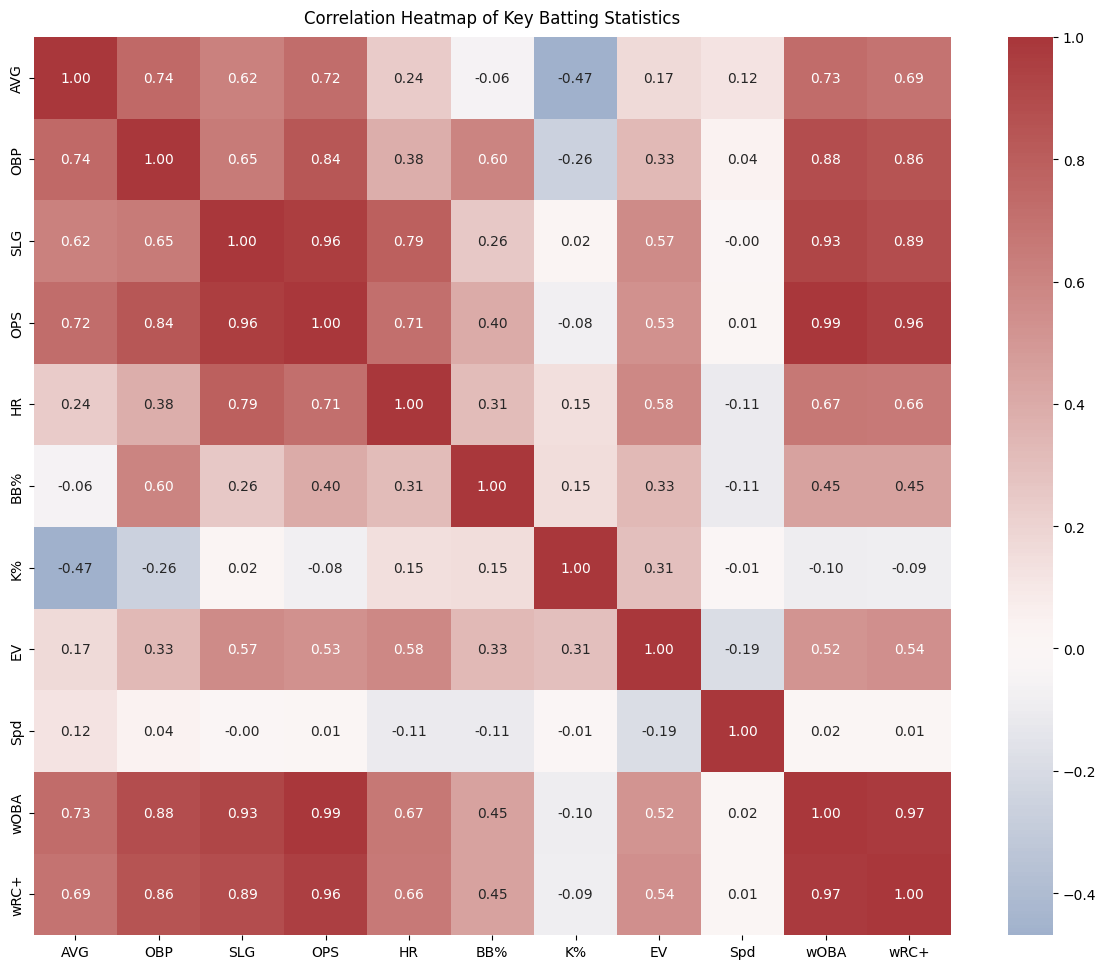

In [116]:
corr_matrix = data[key_stats].corr()

# check most correlated features
high_corr = []
for row in range(len(corr_matrix)):
    for col in range(row + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[row, col]) > 0.8:
            high_corr.append(
                [
                    corr_matrix.iloc[row, col],
                    corr_matrix.columns[row],
                    corr_matrix.columns[col],
                ]
            )


print("Features with high correlation (>= +-0.8):")
high_corr.sort(reverse=True)
for corr, feat1, feat2 in high_corr:
    print(f"{feat1}, {feat2}: {corr}")

# plotting heatmap with seaborn
plt.figure(figsize=(12, 10))
plt.title("Correlation Heatmap of Key Batting Statistics", pad=10)
sns.heatmap(corr_matrix, cmap="vlag", annot=True, fmt=".2f", center=0)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Creating Performance Tiers

One of our potential research questions was whether we could classify hitters into performance tiers.

To do this, we need a target variable to place hitters into these tiers. 

We would like to do this before performing any preprocessing, such as standardization, as it is easier to interpret raw values.

wRC+ is a metric that measures a hitter's offensive output, so we will use this as our target variable. 

According to MLB ([here](https://www.mlb.com/glossary/advanced-stats/weighted-runs-created-plus)): wRC+ takes the statistic Runs Created and adjusts that number to account for important external factors -- like ballpark or era. It's adjusted, so a wRC+ of 100 is league average and 150 would be 50 percent above league average.

**While we could simply predict wRC+ using regression, classification into tiers provides more interpretable categories. A layman could easily understand that a player is "Elite", but may not easily understand what it means for a player to have a wRC+ of 150.**

### Performance Tier Thresholds
We decided to create 4 tiers, as too many thresholds may run into imbalance issues, while too little would not be able to capture different tiers effectively. 

Since the league average is set at 100 wRC+, we will set any samples in that neighbourhood to be average.

Performance Tier
Average          959
Below Average    844
Above Average    678
Elite            384
Name: count, dtype: int64


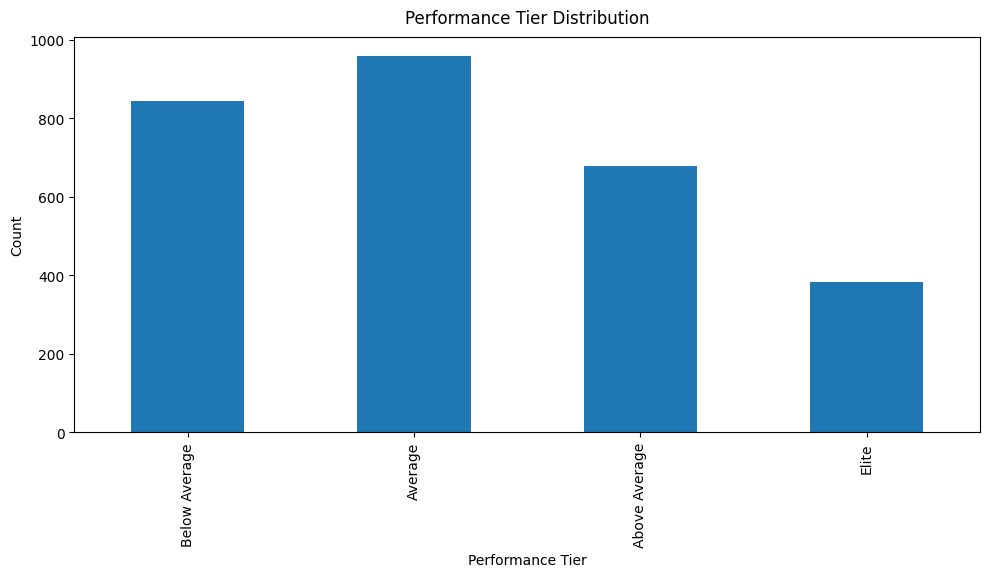

In [117]:
# these tiers are not hard set, but rather estimates of hitter level
def create_performance_tier(wrc_plus):
    if wrc_plus >= 130:
        return "Elite"
    elif wrc_plus >= 110:
        return "Above Average"
    elif wrc_plus >= 90:
        return "Average"
    else:
        return "Below Average"


data["Performance Tier"] = data["wRC+"].apply(create_performance_tier)
custom_order = ["Below Average", "Average", "Above Average", "Elite"]

print(data["Performance Tier"].value_counts())

plt.figure(figsize=(10, 6))
data["Performance Tier"].value_counts().reindex(custom_order).plot(kind="bar")
plt.title("Performance Tier Distribution", pad=10)
plt.ylabel("Count")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# update categorical features after we add new feature
categorical_features = data.select_dtypes(include=["object"]).columns

## Missing Values

We handle missing values by removing or imputing.

### Removing Values

If a feature is missing over 50% of values, it is probably too incomplete to be useful. 

We also don't need player names and ID's, as they are not predictive and would make our model prone to overfitting.

In [118]:
total_missing = data.isna().sum().sum()
print(f"Total missing values before removing: {total_missing}")

print("\nMissing Values:")
missing = data.isna().sum()
missing_pct = (missing / len(data)) * 100

missing_df = pd.DataFrame({"Missing Count": missing, "Percentage": missing_pct})

missing_info = missing_df[missing_df["Missing Count"] > 0].sort_values(
    "Missing Count", ascending=False
)
print(missing_info)

print("Removing features")
# columns missing over 50% of values will be removed
MISSING_THRESHOLD = 50
to_drop = missing_df[missing_df["Percentage"] > MISSING_THRESHOLD].index.tolist()
print(f"\nDropping columns with over {MISSING_THRESHOLD}% of values missing:")
print(to_drop)
data = data.drop(columns=to_drop)

# remove name and ID
data = data.drop(columns=["Name", "IDfg"])

Total missing values before removing: 143010

Missing Values:
           Missing Count  Percentage
PO%                 2865  100.000000
FT% (sc)            2865  100.000000
wFT (sc)            2865  100.000000
FT-Z (sc)           2865  100.000000
FT-X (sc)           2865  100.000000
...                  ...         ...
FS-X (sc)              1    0.034904
vFS (sc)               1    0.034904
xBA                    1    0.034904
xSLG                   1    0.034904
xwOBA                  1    0.034904

[79 rows x 2 columns]
Removing features

Dropping columns with over 50% of values missing:
['KN%', 'KNv', 'PO%', 'wKN', 'wKN/C', 'FT% (sc)', 'FO% (sc)', 'EP% (sc)', 'SC% (sc)', 'KN% (sc)', 'UN% (sc)', 'vFT (sc)', 'vFO (sc)', 'vEP (sc)', 'vSC (sc)', 'vKN (sc)', 'FT-X (sc)', 'FO-X (sc)', 'EP-X (sc)', 'SC-X (sc)', 'KN-X (sc)', 'FT-Z (sc)', 'FO-Z (sc)', 'EP-Z (sc)', 'SC-Z (sc)', 'KN-Z (sc)', 'wFT (sc)', 'wFO (sc)', 'wEP (sc)', 'wSC (sc)', 'wKN (sc)', 'wFT/C (sc)', 'wFO/C (sc)', 'wEP/C (sc)', 

### Imputing Values

Features missing less than 50% of values will be imputed

In [119]:
total_missing = data.isna().sum().sum()
print(f"Total missing values before imputing: {total_missing}")

# numerical values will be imputed using the median
numerical_features = data.select_dtypes(include=[np.number]).columns
data[numerical_features] = data[numerical_features].fillna(
    data[numerical_features].median()
)

# a player missing a team means they were on multiple teams
data["Team"] = data["Team"].fillna("Multiple")
data["Team"] = data["Team"].replace("- - -", "Multiple")

total_missing = data.isna().sum().sum()
print(f"Total missing values remaining: {total_missing}")

Total missing values before imputing: 1009
Total missing values remaining: 0


## Encoding Categorical Features

We will apply one-hot encoding, since teams do not have an ordinal relationship, and our cardinality is not extremely high (31 unique teams).

eg - "Yankees" is not greater than "Blue Jays". There is no order like we have in "Low", "Med", "High".

In [120]:
data = pd.get_dummies(data, columns=["Team"], prefix="Team", drop_first=True)

## Standardize Numerical Features

Baseball stats are prone to outliers.

For example, some players may hit 60 home runs while the league average is around 15.

This suggests that we should standardize rather than normalize.

In [121]:
scaler = StandardScaler()

numerical_features = [feat for feat in data.columns if feat not in categorical_features]
data[numerical_features] = scaler.fit_transform(data[numerical_features])

## Data Augmentation

#### Class Imbalance
After creating performance tiers based on wRC+:
- Elite: 384 players
- Above Average: 678 players  
- Average: 959 players
- Below Average: 844 players

Elite players only make up a small portion of total players. This creates a class imbalance challenge, where the model may be more biased towards the majority classes, and improperly classify minority classes (Elite in our case). We can generate synthetic samples to deal with this problem (SMOTE). 

In [122]:
X = data.drop(columns=["Performance Tier"])
y = data["Performance Tier"]

# split into train test data first
# note for self: no particular reason for radom_state=42. 42 just became convention
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, stratify=y, random_state=42
)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

resampled_counts = y_train_resampled.value_counts()
print("\nClass distribution of training set:")
print(resampled_counts)


Class distribution of training set:
Performance Tier
Below Average    767
Average          767
Elite            767
Above Average    767
Name: count, dtype: int64


## Dimensionality Reduction

Our dataset has high dimensionality, so we try running PCA on it to reduce it to 2 dimensions.

We will also colour-code based on performance tiers. In the below scatter plot, we can see that each colour is decently bunched together in its own area, although there is noticeable overlap. 

This tells we have some class separability, where we can distinguish player tiers. This is a good sign for our model. 

PC1 explains 15.53% of the data
PC2 explains 8.74% of the data
Combined, they explain: 24.27% of all data variation.


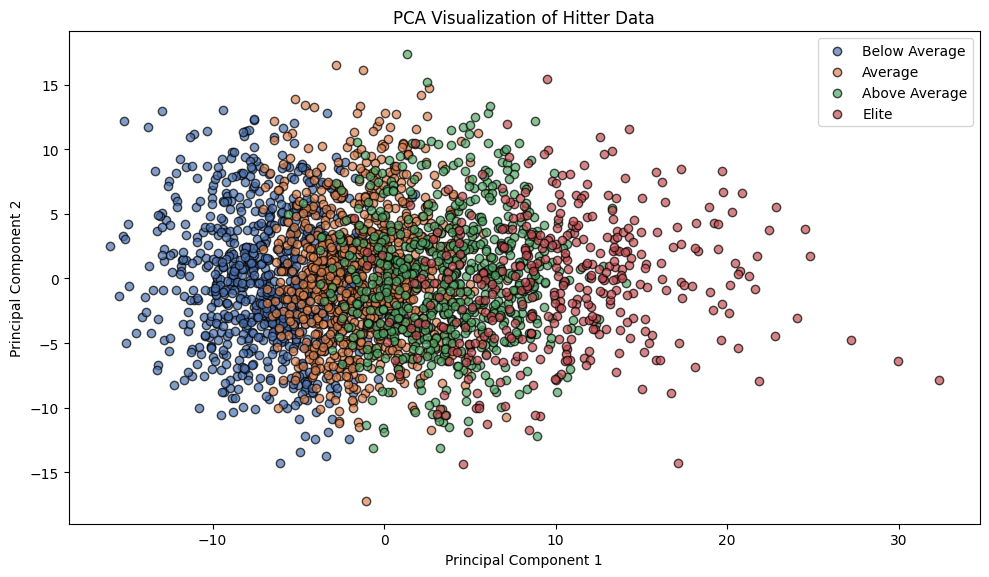

In [123]:
# remove Performance Tier
numeric_data = data.select_dtypes(include=[np.number])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_data)

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the data")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the data")
print(
    f"Combined, they explain: {np.cumsum(pca.explained_variance_ratio_)[1]:.2%} of all data variation."
)

palette = sns.color_palette("deep", 4)
colors = dict(zip(custom_order, palette))

plt.figure(figsize=(10, 6))
# PCA coloured by tiers
for tier in custom_order:
    mask = data["Performance Tier"] == tier
    # mask selects only samples where its tier matches current tier
    plt.scatter(
        pca_result[mask, 0],
        pca_result[mask, 1],
        label=tier,
        alpha=0.7,
        edgecolors="k",
        color=colors[tier],
    )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Hitter Data")
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Saving Cleaned Data

In [124]:
data.to_csv("../data/processed/batting_2015_2024_cleaned.csv")

## Discussion

### Key insights from EDA

Visually, from the histograms, we see that most key offensive stats approximate a normal distribution.

#### Correlation
Many key stats are positively correlated, which may be expected. For example, OPS and wRC+ are highly correlated $(\text{Corr} = 0.96)$. OPS and wOBA are even more correlated $(\text{Corr} = 0.99)$. 

We may run into issues with multicollinearity, where highly correlated features contain redundant information.

Some stats have low correlation. For example, Spd and SLG have roughly 0 correlation. Spd and EV are slightly negatively correlated $(\text{Corr} = -0.19)$. This hints at distinct player archetypes mentioned in our proposal: power hitters vs speedsters.

#### Data Augmentation

There was some class imbalance, so we addressed this by generating synthetic samples (SMOTE). This was discussed in more detail above. 

#### PCA
Our 2D PCA representation captures ~24% of the total information present in the original data, which means it doesn't capture the data super well.

This is not surprising as out dataset is highly dimensional, which makes it harder to compress to just 2 dimensions.

Although 2D PCA produced satisfactory results for visualization of our data, it is probably not good enough to be effective in clustering, classification, etc.